# Learning Rate

Die Learning Rate (LR) legt fest, wie stark die Gewichte der Neuronen pro Trainingslauf angepasst werden, und beeinflusst somit direkt die Trainingsgeschwindigkeit des Netzwerkes. Die LR ist ein wichtiger Hyperparameter: Ist sie zu niedrig, kovergiert das Model nur sehr langsam. Ist sie zu hoch, kann die Fehlerfunktion unter Umständen überhaupt nicht minimiert werden. In diesem Notebook werden diese Fälle demonstriert, sowie der LR Finder ausprobiert.

Zuerst wieder das Datenset vorbereiten:

['Ahorn', 'Birke', 'Eiche', 'Kastanie']


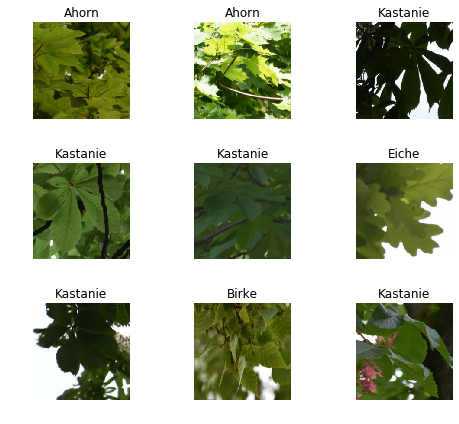

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

path = Path('datasets/leaves')

np.random.seed(1337)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=10,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))
print(data.classes)

## LR gut

Der Default-Wert für die LR ist hier 0.003

In [5]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, max_lr=slice(None, 0.003, None))

epoch,train_loss,valid_loss,error_rate,time
0,0.872766,0.369310,0.122905,00:04
1,0.655602,0.255218,0.100559,00:04
2,0.440981,0.202692,0.078212,00:04
3,0.353038,0.242799,0.094972,00:04


## LR zu niedrig

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, max_lr=slice(None, 0.00001, None))

epoch,train_loss,valid_loss,error_rate,time
0,1.706942,1.473615,0.670391,00:04
1,1.728150,1.419150,0.642458,00:04
2,1.671096,1.423881,0.636872,00:04
3,1.597217,1.398891,0.597765,00:04


Auch nach vier Epochen ist das Training hier noch nicht so weit wie nach einer Epoche mit LR = 0.003

## LR zu hoch

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, max_lr=slice(None, 0.9, None))

epoch,train_loss,valid_loss,error_rate,time
0,115.927727,2926.285889,0.837989,00:04
1,550.076721,373.372589,0.642458,00:04
2,307.403656,158.431580,0.581006,00:04
3,128.607193,76.254936,0.463687,00:04


Konvergiert ebenfalls nicht gut, Error Rate wird stellenweise sogar höher.

## Models speichern und laden

Um trainierte Models zu speichern kann folgender Befehl verwendet werden (per default wird im jeweiligen Datenset-Ordner ein "models" Verzeichnis angelegt):

In [10]:
learn.save("trained_model", return_path=True)

PosixPath('datasets/leaves/models/trained_model.pth')

Laden von Models mit:

In [11]:
learn = learn.load("trained_model")

## Learning Rate Finder

In der Praxis hat sich gezeigt, dass LRs, die im Verlauf des Trainings angepasst werden, zu den besten Ergebnissen führen. In fast.ai werden "Cyclical Learning Rates" verwendet. Diese schwanken im Trainingsverlauf linear zwischen einem Maximalwert max_lr und einem Minimalwert base_lr: 

<img src="images/clr.JPG">

Mit dem Learning Rate Finder können geeignete Werte gefunden werden. Als Daumenregel ist eine geeignete max_lr bei dem Wert, bei dem die Kurve für den Loss anfängt, stark abzufallen:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


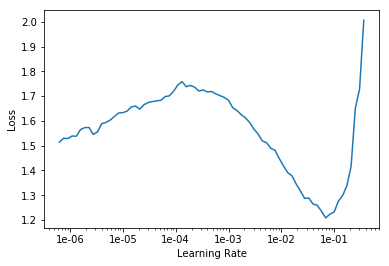

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

Hier sieht man, das Werte ab 0,001 gut für max_lr geeignet sind.